<a href="https://colab.research.google.com/github/AbdelrahmanKK/NoduleMNIST3D-classification/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install and import dependencies

In [ ]:
|!pip install medmnist
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=ea03b69cabd94dbfcf36ac8944f1551838f15c7a0ae580c9247f853ff93ab06a
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot as plt
import medmnist
from medmnist import NoduleMNIST3D

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from numpy.random.mtrand import random
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    NormalizeIntensity
)

from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/drive
cpu


In [ ]:
# dataset
data_name = 'nodulemnist3d'
info = medmnist.INFO[data_name]
n_channels = info['n_channels']
n_classes = len(info['label'])
print(info)

{'python_class': 'NoduleMNIST3D', 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.', 'url': 'https://zenodo.org/record/6496656/files/nodulemnist3d.npz?download=1', 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3', 'task': 'binary-class', 'label': {'0': 'benign', '1': 'malignant'}, 'n_channels': 1, 'n_samples': {'train': 1158, 'val': 165, 'test': 310}, 'license': 'CC BY 4.0'}


In [ ]:
# transforms = v2.Compose([
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])


# transforms =  Compose([

#                   ScaleIntensity(minv=1,maxv=2),
#                   RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
#                   RandFlip(spatial_axis=0, prob=0.5),
#                   ])

transforms = Compose([
    ToTensor(),
    NormalizeIntensity()
])




# Download Dataset

### Split from "MedMNIST v2" paper is
### Train : Validation : Test = 7 : 1 : 2



In [ ]:
test_dataset = NoduleMNIST3D(split='test', transform = transforms, download=True)

print(test_dataset)


100%|██████████| 29299364/29299364 [00:02<00:00, 11490187.53it/s]


Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 310
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.
    License: CC BY 4.0


# Create data loader

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=80, shuffle=False)


# Visulaization

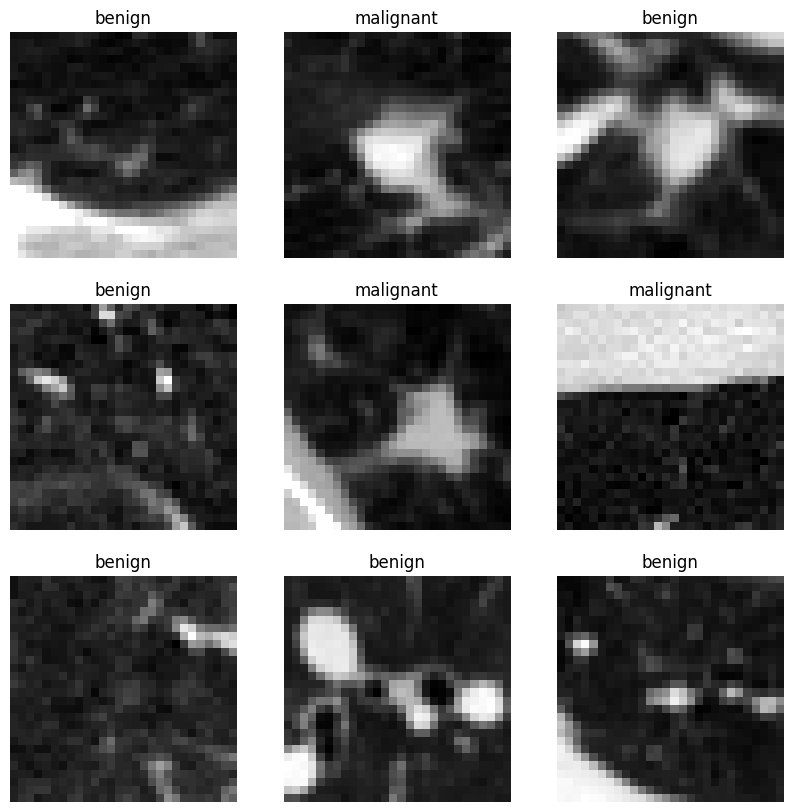

In [ ]:

labels_map = {
    0: "benign",
    1: "malignant",
}


random_batch = next(iter(test_loader))
images = random_batch[0]
labels = random_batch[1]
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    index = np.random.randint(0, len(images))
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[index][0].permute(1, 2, 0)[:,:,12],cmap = "gray")

    plt.axis('off')
    plt.title(labels_map[torch.IntTensor.item(labels[index][0])])


# Check the count of each class

benign = 246
maliginant = 64


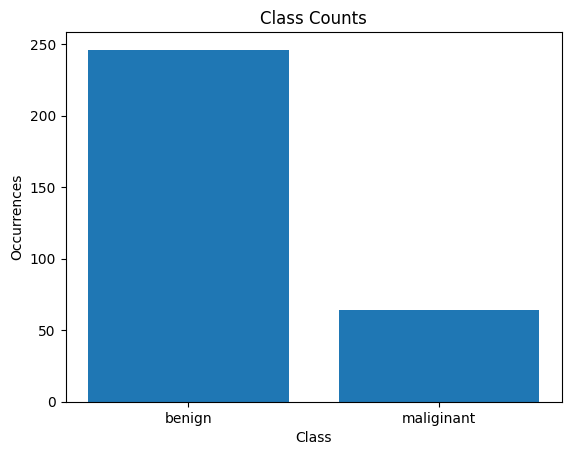

In [ ]:
class_names = ['benign', 'maliginant']
class_counts = [0, 0]

for batch ,labels in test_loader:
    for label in labels:
        class_counts[label] += 1

print(class_names[0] +' = '+ str(class_counts[0]))
print(class_names[1] +' = '+ str(class_counts[1]))
x_pos = np.arange(len(class_names))
plt.bar(x_pos, class_counts)
plt.xticks(x_pos, class_names)
plt.xlabel('Class')
plt.ylabel('Occurrences')
plt.title('Class Counts')
plt.show()

In [ ]:

def test(data_loader, model, criterion):
    test_loss_values = []
    predictions = []
    actuals = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            images=images.float()

            outputs = model(images)
            loss = criterion(outputs.float(), labels.float())
            test_loss_values.append(loss.item())

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    AUC = roc_auc_score(actuals, predictions)
    ACC = accuracy_score(np.round(predictions), actuals)

    return actuals ,predictions, AUC, ACC

# Simple 5-layer 3D CNN implementation
#### **Model Architecture**



- in_channels:  number of input channels, ,will be 1 for our example
- num_classes:  number of classes

#### The layers and their operations are as follows:
1. layer1: Convolutional layer with 16 filters, batch normalization, and ReLU activation.
2. layer2: Convolutional layer with 16 filters, batch normalization, ReLU activation, and max-pooling.
3. layer3: Convolutional layer with 64 filters, batch normalization, and ReLU activation.
4. layer4: Convolutional layer with 64 filters, batch normalization, and ReLU activation.
5. layer5: Convolutional layer with 64 filters, batch normalization, ReLU activation, and max-pooling.
6. fullyconnected: Fully connected layers for classification.

In [ ]:
class CNN_3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_3D, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, kernel_size=3),
            nn.BatchNorm3d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 64, kernel_size=3),
            nn.BatchNorm3d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3),
            nn.BatchNorm3d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))

        self.fullyconnected = nn.Sequential(
            nn.Linear(64*4*4*4 , 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.layer1(x.float())
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fullyconnected(x)
        x = torch.sigmoid(x)
        return x


model = CNN_3D(in_channels=n_channels, num_classes=n_classes).to(device)




# Model loading

In [ ]:
PATH = "drive/MyDrive/nodule_3d/CNN_model"
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
criterion = nn.BCELoss()

In [ ]:
actuals ,predictions, AUC_test, ACC_test = test(test_loader, model,criterion)

print(f' Test    ---> AUC: {AUC_test:.3f}, ACC: {ACC_test:.3f}')

 Test    ---> AUC: 0.923, ACC: 0.868


# Receiver Operating Characteristic (ROC) Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. [(Reference)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=An%20ROC%20curve%20(receiver%20operating,True%20Positive%20Rate). This curve plots two parameters:

*   True Positive Rate
*   False Positive Rate




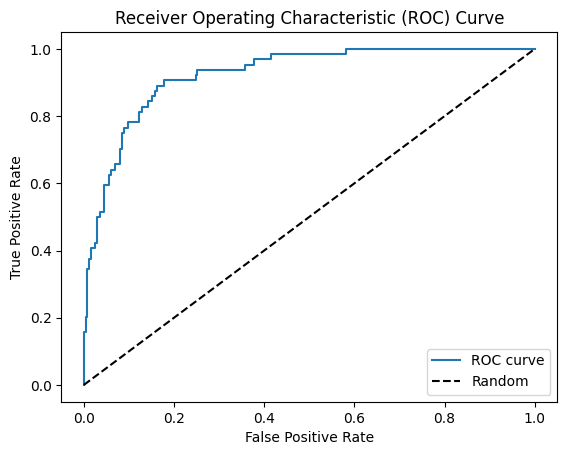

In [ ]:
fpr, tpr, thresholds = roc_curve(actuals, predictions)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Results Visualization

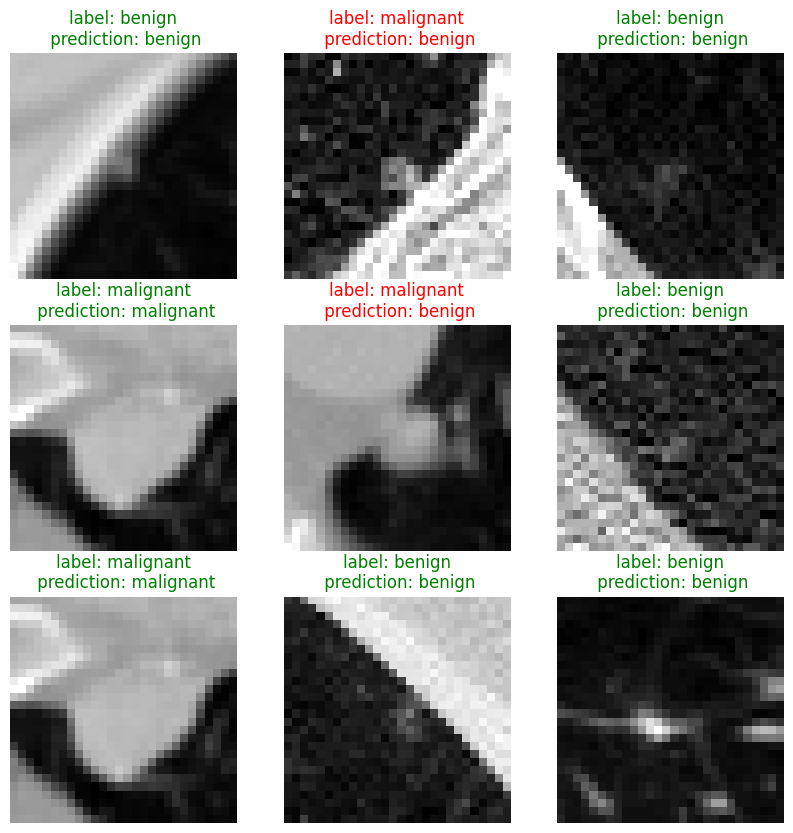

In [ ]:

labels_map = {
    0: "benign",
    1: "malignant",
}



fig = plt.figure(figsize=(10, 10))
for i in range(9):
    index = np.random.randint(0, len(test_dataset))
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_dataset[index][0][0].permute(1, 2, 0)[:,:,12],cmap = "gray")
    plt.axis('off')
    prediction = (0 if predictions[index] < .5 else 1)

    plt.title("label: "+str(labels_map[actuals[index][0]])+ "\n prediction: "+ str(labels_map[prediction]),color="green" if prediction == actuals[index] else "red" )

# (############)